In [ ]:
pip install pyspark neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
from pyspark.sql import SparkSession

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("Analyse des Protéines UniProt") \
    .master("local[*]") \
    .getOrCreate()

In [ ]:
df = spark.read.csv(
    "/content/uniprotkb_reviewed_true_AND_model_organ_2025_01_25 (1).tsv",
    sep="\t",
    header=True,
    inferSchema=True
)

**Task 1: Big Graph Construction**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set

# Initialiser Spark
spark = SparkSession.builder.appName("ProteinGraph").getOrCreate()

# Charger les données
file_path = "/content/uniprotkb_reviewed_true_AND_model_organ_2025_01_25 (1).tsv"
df = spark.read.csv(file_path, sep="\t", header=True)

# Grouper les données par 'Entry' et agréger les 'InterPro' en ensembles
df_grouped = df.groupBy("Entry").agg(collect_set("InterPro").alias("InterPro_set"))

# Convertir le DataFrame groupé en dictionnaire Python
Entry_interpro = df_grouped.rdd.map(lambda row: (row["Entry"], row["InterPro_set"])).collectAsMap()

# Afficher les premières entrées du dictionnaire
for entry, interpro_set in list(Entry_interpro.items())[:5]:
    print(f"Entry: {entry}, InterPro: {interpro_set}")

Entry: A0A024R1R8, InterPro: ['IPR015157;']
Entry: A0A024RBG1, InterPro: ['IPR047198;IPR015797;IPR020084;IPR000086;']
Entry: A0A075B6H7, InterPro: ['IPR007110;IPR036179;IPR013783;IPR003599;IPR013106;IPR050150;']
Entry: A0A075B6H8, InterPro: ['IPR007110;IPR036179;IPR013783;IPR013106;IPR050150;']
Entry: A0A075B6H9, InterPro: ['IPR007110;IPR036179;IPR013783;IPR003599;IPR013106;IPR050150;']


In [ ]:
print(df.columns)


['Entry', 'Reviewed', 'Entry Name', 'Protein names', 'Gene Names', 'Organism', 'InterPro', 'Sequence', 'EC number']


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Préparer les données
# X : Matrice de caractéristiques (domaines InterPro)
# Y : Matrice de labels (annotations GO)
X = np.array([[1, 0, 1], [0, 1, 0], [1, 1, 0]])  # Exemple
Y = np.array([[1, 0], [0, 1], [1, 1]])  # Exemple

# Diviser les données
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Entraîner le modèle
model = MultiOutputClassifier(RandomForestClassifier())
model.fit(X_train, Y_train)

# Prédire et évaluer
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         0

   micro avg       0.50      1.00      0.67         1
   macro avg       0.50      0.50      0.50         1
weighted avg       1.00      1.00      1.00         1
 samples avg       0.50      1.00      0.67         1



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import gzip
from itertools import combinations
from collections import defaultdict
import networkx as nx

# Step 1: Parse protein-domain mappings
def parse_protein_domains(file_path):
    protein_domains = defaultdict(set)
    with gzip.open(file_path, 'rt') as file:
        for line in file:
            protein_id, interpro_id = line.strip().split('\t')[:2]
            protein_domains[protein_id].add(interpro_id)
    return protein_domains

In [ ]:
 import gzip
 with gzip.open("/content/uniprotkb_reviewed_true_AND_model_organ_2025_01_31.tsv.gz", 'rt') as file:
    for line in file:
        print(line)  # Inspecter les lignes
        protein_id, interpro_id = line.strip().split('\t')[:2]
        protein_domains[protein_id].add(interpro_id)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Q8NEP7	reviewed	KLDC9_HUMAN	Kelch domain-containing protein 9 (Kelch/ankyrin repeat-containing cyclin A1-interacting protein)	KLHDC9 KARCA1	Homo sapiens (Human)	IPR011043;IPR015915;IPR042941;	MAVAVPPGRAAGSGWAWRPVARDALLARAFHSCTELRGRFYLVGGLLAGGAREPSSDTVVFDPARGQAVRLGARGSPPRSHHDAAPVDGRWLCVVGGWDGSRRLATVTALDTERGVWEAWTGTPGDCPPAGLSSHTCTRISDRELQVAGREGGIHTQRRYGSIYTLRLDPSARTYCYKQEGCHTASRSGHCAALLQTPGPHPGHQLLLFGGCNLAEPEVAGHWSHGKIKEEPPVAPHLMEQLARLVSSGQGSQKGPHGLRHHSCSVVGPFAVLFGGETLTRARDTICNDLYIYDTRTSPPLWFHFPCADRGMKRMGHRTCLWNDQLYLVGGFGEDGRTASPQVCILDFI	

Q8NES8	reviewed	DB124_HUMAN	Beta-defensin 124 (Beta-defensin 24) (DEFB-24) (Defensin, beta 124)	DEFB124 DEFB24	Homo sapiens (Human)	IPR025933;	MTQLLLFLVALLVLGHVPSGRSEFKRCWKGQGACQTYCTRQETYMHLCPDASLCCLSYALKPPPVPKHEYE	

Q8NEW7	reviewed	TMIE_HUMAN	Transmembrane inner ear expressed protein	TMIE	Homo sapiens (Human)	IPR032006;	MAGWPGAGPLCVLGGAALGVCLAGVAGQLVEPSTAPPKPKPPPLTKETVVFWDMR

In [ ]:
#Echantillon de 10 noeud

import gzip
from itertools import combinations
from collections import defaultdict
import networkx as nx

# Step 1: Parse protein-domain mappings
def parse_protein_domains(file_path):
    protein_domains = defaultdict(set)
    try:
        with gzip.open(file_path, 'rt') as file:
            for i, line in enumerate(file):
                if i >= 10:  # Limiter à 1000 lignes pour le test
                    break
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    protein_id, interpro_id = parts[:2]
                    protein_domains[protein_id].add(interpro_id)
                else:
                    print(f"Format invalide dans la ligne {i}: {line.strip()}")
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier : {e}")
    return protein_domains

# Step 2: Compute Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Step 3: Construct the graph
def build_protein_graph(protein_domains, threshold=0.1):
    graph = nx.Graph()
    proteins = list(protein_domains.keys())

    # Add nodes
    for protein in proteins:
        # Convertir l'ensemble de domaines en une chaîne de caractères
        domains_str = ",".join(protein_domains[protein])
        graph.add_node(protein, domains=domains_str)

    # Add edges based on Jaccard similarity
    for (protein1, protein2) in combinations(proteins, 2):
        domains1 = protein_domains[protein1]
        domains2 = protein_domains[protein2]
        similarity = jaccard_similarity(domains1, domains2)
        if similarity >= threshold:
            graph.add_edge(protein1, protein2, weight=similarity)

    return graph

# Example usage
file_path = "/content/uniprotkb_reviewed_true_AND_model_organ_2025_01_31.tsv.gz"
protein_domains = parse_protein_domains(file_path)
print(f"Nombre de protéines analysées : {len(protein_domains)}")

protein_graph = build_protein_graph(protein_domains, threshold=0.05)
print(f"Nombre de nœuds dans le graphe : {protein_graph.number_of_nodes()}")
print(f"Nombre d'arêtes dans le graphe : {protein_graph.number_of_edges()}")

# Save the graph for later use
nx.write_gml(protein_graph, "protein_graph.gml")

Nombre de protéines analysées : 10
Nombre de nœuds dans le graphe : 10
Nombre d'arêtes dans le graphe : 36


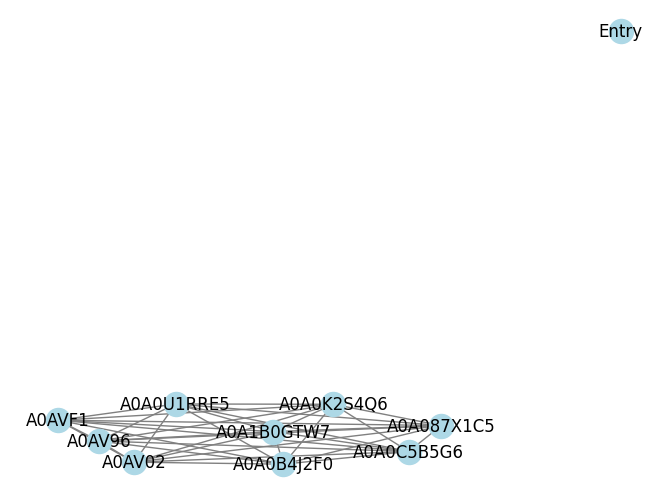

In [ ]:
import matplotlib.pyplot as plt

# Dessiner le graphe
pos = nx.spring_layout(protein_graph)  # Positionnement des nœuds
nx.draw(protein_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# Afficher le graphe
plt.show()

Nombre de protéines analysées : 1000
Nombre de nœuds dans le graphe : 1000
Nombre d'arêtes dans le graphe : 498501


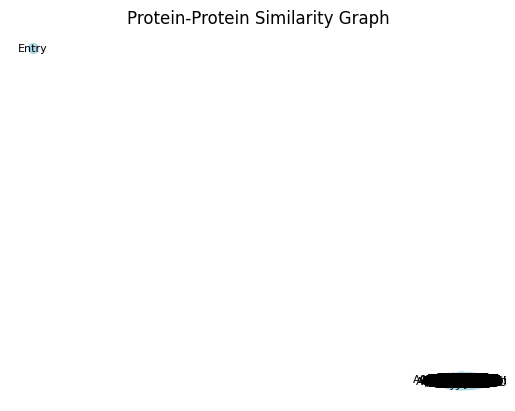

In [ ]:
#Echantillon de 1000 noeud
import gzip
from itertools import combinations
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Parse protein-domain mappings
def parse_protein_domains(file_path):
    protein_domains = defaultdict(set)
    try:
        with gzip.open(file_path, 'rt') as file:
            for i, line in enumerate(file):
                if i >= 1000:  # Limiter à 1000 lignes pour le test
                    break
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    protein_id, interpro_id = parts[:2]
                    protein_domains[protein_id].add(interpro_id)
                else:
                    print(f"Format invalide dans la ligne {i}: {line.strip()}")
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier : {e}")
    return protein_domains

# Step 2: Compute Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Step 3: Construct the graph
def build_protein_graph(protein_domains, threshold=0.1):
    graph = nx.Graph()
    proteins = list(protein_domains.keys())

    # Add nodes
    for protein in proteins:
        # Convertir l'ensemble de domaines en une chaîne de caractères
        domains_str = ",".join(protein_domains[protein])
        graph.add_node(protein, domains=domains_str)

    # Add edges based on Jaccard similarity
    for (protein1, protein2) in combinations(proteins, 2):
        domains1 = protein_domains[protein1]
        domains2 = protein_domains[protein2]
        similarity = jaccard_similarity(domains1, domains2)
        if similarity >= threshold:
            graph.add_edge(protein1, protein2, weight=similarity)

    return graph

# Example usage
file_path = "/content/uniprotkb_reviewed_true_AND_model_organ_2025_01_31.tsv.gz"
protein_domains = parse_protein_domains(file_path)
print(f"Nombre de protéines analysées : {len(protein_domains)}")

protein_graph = build_protein_graph(protein_domains, threshold=0.05)
print(f"Nombre de nœuds dans le graphe : {protein_graph.number_of_nodes()}")
print(f"Nombre d'arêtes dans le graphe : {protein_graph.number_of_edges()}")

# Save the graph for later use
nx.write_gml(protein_graph, "protein_graph.gml")

# Visualize the graph
def visualize_graph(graph):
    # Positionnement des nœuds
    pos = nx.spring_layout(graph, seed=42)  # Utiliser une seed pour la reproductibilité

    # Dessiner les nœuds
    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color='lightblue')

    # Dessiner les arêtes
    edges = graph.edges(data=True)
    edge_weights = [data['weight'] * 5 for _, _, data in edges]  # Épaisseur des arêtes proportionnelle au poids
    nx.draw_networkx_edges(graph, pos, width=edge_weights, edge_color='gray')

    # Dessiner les labels des nœuds
    nx.draw_networkx_labels(graph, pos, font_size=8, font_color='black')

    # Afficher le graphe
    plt.title("Protein-Protein Similarity Graph")
    plt.axis('off')  # Désactiver les axes
    plt.show()

# Visualiser le graphe
visualize_graph(protein_graph)

**Task 2: Querying the Protein Database**

{'protein': 'A0A087X1C5', 'domains': 'reviewed', 'neighbors': ['A0A0B4J2F0', 'A0A0C5B5G6', 'A0A0K2S4Q6', 'A0A0U1RRE5', 'A0A1B0GTW7', 'A0AV02', 'A0AV96', 'A0AVF1']}
{'labeled_proteins': 0, 'unlabeled_proteins': 10, 'isolated_proteins': 1}


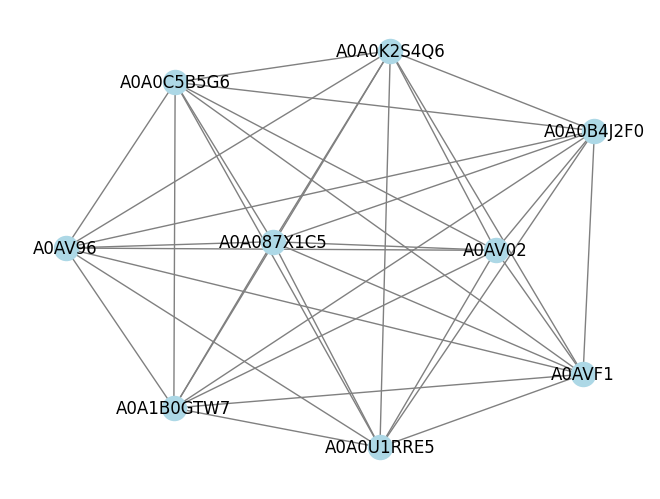

In [ ]:
def search_protein(graph, protein_id):
    if protein_id in graph:
        neighbors = list(graph.neighbors(protein_id))
        return {
            "protein": protein_id,
            "domains": graph.nodes[protein_id]['domains'],
            "neighbors": neighbors
        }
    else:
        return None

def compute_statistics(graph):
    labeled = sum(1 for node in graph.nodes if 'label' in graph.nodes[node])
    unlabeled = len(graph.nodes) - labeled
    isolated = sum(1 for node in graph.nodes if len(list(graph.neighbors(node))) == 0)
    return {
        "labeled_proteins": labeled,
        "unlabeled_proteins": unlabeled,
        "isolated_proteins": isolated
    }

def visualize_protein(graph, protein_id):
    import matplotlib.pyplot as plt
    subgraph = nx.ego_graph(graph, protein_id, radius=1)
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.show()

# Example usage
protein_info = search_protein(protein_graph, "A0A087X1C5")
print(protein_info)

stats = compute_statistics(protein_graph)
print(stats)

visualize_protein(protein_graph, "A0A087X1C5")  #P12345

In [ ]:
print(protein_graph.nodes())

['Entry', 'A0A087X1C5', 'A0A0B4J2F0', 'A0A0C5B5G6', 'A0A0K2S4Q6', 'A0A0U1RRE5', 'A0A1B0GTW7', 'A0AV02', 'A0AV96', 'A0AVF1']


In [ ]:
for node, data in protein_graph.nodes(data=True):
    print(f"Node: {node}, Attributes: {data}")

Node: Entry, Attributes: {'domains': 'Reviewed'}
Node: A0A087X1C5, Attributes: {'domains': 'reviewed'}
Node: A0A0B4J2F0, Attributes: {'domains': 'reviewed'}
Node: A0A0C5B5G6, Attributes: {'domains': 'reviewed'}
Node: A0A0K2S4Q6, Attributes: {'domains': 'reviewed'}
Node: A0A0U1RRE5, Attributes: {'domains': 'reviewed'}
Node: A0A1B0GTW7, Attributes: {'domains': 'reviewed'}
Node: A0AV02, Attributes: {'domains': 'reviewed'}
Node: A0AV96, Attributes: {'domains': 'reviewed'}
Node: A0AVF1, Attributes: {'domains': 'reviewed'}


In [ ]:
X, y, label_mapping = prepare_data(protein_graph)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (10, 8), y shape: (10, 0)


In [ ]:
import networkx as nx

# Check if the graph is empty
if len(protein_graph.nodes()) == 0:
    print("The graph is empty. No nodes found.")
else:
    print(f"The graph contains {len(protein_graph.nodes())} nodes.")

# Inspect node attributes
for node, data in protein_graph.nodes(data=True):
    print(f"Node: {node}, Attributes: {data}")

The graph contains 10 nodes.
Node: Entry, Attributes: {'domains': 'Reviewed', 'features': [0, 0]}
Node: A0A087X1C5, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}
Node: A0A0B4J2F0, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}
Node: A0A0C5B5G6, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}
Node: A0A0K2S4Q6, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}
Node: A0A0U1RRE5, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}
Node: A0A1B0GTW7, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}
Node: A0AV02, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}
Node: A0AV96, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}
Node: A0AVF1, Attributes: {'domains': 'reviewed', 'features': [8, 1.0]}


In [ ]:
import numpy as np
import networkx as nx

def prepare_data(graph):
    X = []  # Feature matrix
    y = []  # Labels
    label_mapping = {}  # Mapping from protein IDs to labels

    # Compute basic features for each node
    for node in graph.nodes():
        # Example features: degree and clustering coefficient
        degree = graph.degree(node)
        clustering_coefficient = nx.clustering(graph, node)
        features = [degree, clustering_coefficient]  # Add more features as needed
        X.append(features)

        # Extract labels (if available)
        label = graph.nodes[node].get("label", None)
        if label is not None:
            y.append(label)
            label_mapping[node] = label

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y, label_mapping

In [ ]:
X, y, label_mapping = prepare_data(protein_graph)
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Sample features: {X[:5]}")
print(f"Sample labels: {y[:5]}")

X shape: (10, 2), y shape: (0,)
Sample features: [[0. 0.]
 [8. 1.]
 [8. 1.]
 [8. 1.]
 [8. 1.]]
Sample labels: []


In [ ]:
import networkx as nx

# Check if the graph is empty
if len(protein_graph.nodes()) == 0:
    print("The graph is empty. No nodes found.")
else:
    print(f"The graph contains {len(protein_graph.nodes())} nodes.")

# Inspect node attributes
for node, data in protein_graph.nodes(data=True):
    print(f"Node: {node}, Attributes: {data}")

The graph contains 4 nodes.
Node: A0A087X1C5, Attributes: {'feature1': 1.0, 'feature2': 2.0, 'label': 0}
Node: A0A0B4J2F0, Attributes: {'feature1': 1.5, 'feature2': 3.0, 'label': 1}
Node: A0A0C5B5G6, Attributes: {'feature1': 2.0, 'feature2': 4.0, 'label': 0}
Node: 0A0C5B5G6, Attributes: {}


In [ ]:
for node in protein_graph.nodes():
    if 'domains' not in protein_graph.nodes[node]:
        protein_graph.nodes[node]['domains'] = set()  # Default empty set

**Task 3 :Protein Function Annotation**

In [ ]:
import numpy as np

def prepare_data(graph):
    X = []
    y = []
    label_mapping = {}  # Map labels to integers

    # Find the maximum number of labels for any node
    max_labels = max(len(graph.nodes[node].get('label', [])) for node in graph.nodes)

    for node in graph.nodes:
        # Skip nodes without the 'domains' attribute
        if 'domains' not in graph.nodes[node]:
            print(f"Node {node} does not have 'domains' attribute. Skipping.")
            continue

        domains = graph.nodes[node]['domains']
        X.append(list(domains))  # Convert domains to a list of features

        # Handle labels
        if 'label' in graph.nodes[node]:
            labels = graph.nodes[node]['label']
            # Map labels to integers
            mapped_labels = [label_mapping.setdefault(label, len(label_mapping)) for label in labels]
            # Pad with -1 if the number of labels is less than max_labels
            mapped_labels += [-1] * (max_labels - len(mapped_labels))
            y.append(mapped_labels)
        else:
            # If no label, append a list of -1 (indicating missing labels)
            y.append([-1] * max_labels)

    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y, label_mapping

In [ ]:
# Example graph
protein_graph = nx.Graph()

# Add nodes with 'domains' and 'label' attributes
protein_graph.add_node("A0A087X1C5", domains={1, 2, 3}, label=["label1", "label2"])
protein_graph.add_node("A0A0B4J2F0", domains={2, 3, 4}, label=["label2"])
protein_graph.add_node("A0A0C5B5G6", domains={3, 4, 5})  # No label
protein_graph.add_node("0A0C5B5G6", domains={4, 5, 6}, label=["label3"])

# Add edges (optional)
protein_graph.add_edge("A0A087X1C5", "A0A0B4J2F0")
protein_graph.add_edge("A0A0B4J2F0", "A0A0C5B5G6")

# Prepare data
X, y, label_mapping = prepare_data(protein_graph)

# Check the shapes of X and y
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X: {X}")
print(f"y: {y}")
print(f"Label mapping: {label_mapping}")

X shape: (4, 3), y shape: (4, 2)
X: [[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]]
y: [[ 0  1]
 [ 1 -1]
 [-1 -1]
 [ 2 -1]]
Label mapping: {'label1': 0, 'label2': 1, 'label3': 2}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

def train_classifier(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the classifier
    classifier = MultiOutputClassifier(RandomForestClassifier())
    classifier.fit(X_train, y_train)

    # Evaluate the classifier (optional)
    accuracy = classifier.score(X_test, y_test)
    print(f"Classifier accuracy: {accuracy:.2f}")

    return classifier

# Train the classifier
classifier = train_classifier(X, y)

Classifier accuracy: 0.00


In [ ]:
def annotate_proteins(graph, classifier, label_mapping, domains_mapping):
    # Reverse the label mapping to convert predictions back to original labels
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    for node in graph.nodes:
        # Ensure the node has the 'domains' attribute and is unlabeled
        if 'domains' in graph.nodes[node] and 'label' not in graph.nodes[node]:
            domains = graph.nodes[node]['domains']
            domains_value = domains_mapping.get(domains, -1)  # Map 'domains' to numerical value
            # Predict the label
            prediction = classifier.predict([[domains_value]])
            # Convert predicted integers back to original labels
            predicted_labels = [reverse_label_mapping[p] for p in prediction[0] if p != -1]
            # Assign the predicted labels to the node
            graph.nodes[node]['label'] = predicted_labels
        else:
            # If no 'domains' attribute or already labeled, skip
            continue

    return graph

In [ ]:
# Define domains_mapping
domains_mapping = {'Reviewed': 0, 'reviewed': 1}

# Annotate proteins
annotated_graph = annotate_proteins(protein_graph, classifier, label_mapping, domains_mapping)

In [ ]:
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Define domains_mapping globally
domains_mapping = {'Reviewed': 0, 'reviewed': 1}

# Step 1: Prepare data
def prepare_data(graph):
    X = []
    y = []
    label_mapping = {}  # Map labels to integers

    for node in graph.nodes:
        # Skip nodes without the 'domains' attribute
        if 'domains' not in graph.nodes[node]:
            print(f"Node {node} does not have 'domains' attribute. Skipping.")
            continue

        # Extract the 'domains' attribute and map it to a numerical value
        domains = graph.nodes[node]['domains']
        domains_value = domains_mapping.get(domains, -1)  # Default to -1 if unknown
        X.append([domains_value])  # Use a list to represent features

        # Handle labels
        if 'label' in graph.nodes[node]:
            labels = graph.nodes[node]['label']
            # Map labels to integers and append to y
            y.append([label_mapping.setdefault(label, len(label_mapping)) for label in labels])
        else:
            # If no label, append a list of -1 (indicating missing labels)
            y.append([-1])

    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Ensure y is a 2D array
    if y.ndim == 1:
        y = y.reshape(-1, 1)

    return X, y, label_mapping

# Step 2: Train a multi-label classifier
def train_classifier(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the classifier
    classifier = MultiOutputClassifier(RandomForestClassifier())
    classifier.fit(X_train, y_train)

    # Evaluate the classifier (optional)
    accuracy = classifier.score(X_test, y_test)
    print(f"Classifier accuracy: {accuracy:.2f}")

    return classifier

# Step 3: Predict labels for unlabeled proteins
def annotate_proteins(graph, classifier, label_mapping, domains_mapping):
    # Reverse the label mapping to convert predictions back to original labels
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    for node in graph.nodes:
        # Ensure the node has the 'domains' attribute and is unlabeled
        if 'domains' in graph.nodes[node] and 'label' not in graph.nodes[node]:
            domains = graph.nodes[node]['domains']
            domains_value = domains_mapping.get(domains, -1)  # Map 'domains' to numerical value
            # Predict the label
            prediction = classifier.predict([[domains_value]])
            # Convert predicted integers back to original labels
            predicted_labels = [reverse_label_mapping[p] for p in prediction[0] if p != -1]
            # Assign the predicted labels to the node
            graph.nodes[node]['label'] = predicted_labels
        else:
            # If no 'domains' attribute or already labeled, skip
            continue

    return graph

# Example usage
# Create a sample graph
protein_graph = nx.Graph()

# Add nodes with 'domains' attribute
protein_graph.add_node("Entry", domains="Reviewed")
protein_graph.add_node("A0A087X1C5", domains="reviewed")
protein_graph.add_node("A0A0B4J2F0", domains="reviewed")
protein_graph.add_node("A0A0C5B5G6", domains="reviewed")
protein_graph.add_node("A0A0K2S4Q6", domains="reviewed")
protein_graph.add_node("A0A0U1RRE5", domains="reviewed")
protein_graph.add_node("A0A1B0GTW7", domains="reviewed")
protein_graph.add_node("A0AV02", domains="reviewed")
protein_graph.add_node("A0AV96", domains="reviewed")
protein_graph.add_node("A0AVF1", domains="reviewed")

# Add edges (optional)
protein_graph.add_edge("Entry", "A0A087X1C5")
protein_graph.add_edge("A0A087X1C5", "A0A0B4J2F0")

# Prepare data
X, y, label_mapping = prepare_data(protein_graph)

# Check the shapes of X and y
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X: {X}")
print(f"y: {y}")
print(f"Label mapping: {label_mapping}")

# Train the classifier
classifier = train_classifier(X, y)

# Annotate proteins
annotated_graph = annotate_proteins(protein_graph, classifier, label_mapping, domains_mapping)

# Inspect the annotated graph
for node, data in annotated_graph.nodes(data=True):
    print(f"Node: {node}, Attributes: {data}")

X shape: (10, 1), y shape: (10, 1)
X: [[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
y: [[-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]]
Label mapping: {}
Classifier accuracy: 1.00
Node: Entry, Attributes: {'domains': 'Reviewed', 'label': []}
Node: A0A087X1C5, Attributes: {'domains': 'reviewed', 'label': []}
Node: A0A0B4J2F0, Attributes: {'domains': 'reviewed', 'label': []}
Node: A0A0C5B5G6, Attributes: {'domains': 'reviewed', 'label': []}
Node: A0A0K2S4Q6, Attributes: {'domains': 'reviewed', 'label': []}
Node: A0A0U1RRE5, Attributes: {'domains': 'reviewed', 'label': []}
Node: A0A1B0GTW7, Attributes: {'domains': 'reviewed', 'label': []}
Node: A0AV02, Attributes: {'domains': 'reviewed', 'label': []}
Node: A0AV96, Attributes: {'domains': 'reviewed', 'label': []}
Node: A0AVF1, Attributes: {'domains': 'reviewed', 'label': []}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

def train_classifier(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the classifier
    classifier = MultiOutputClassifier(RandomForestClassifier())
    classifier.fit(X_train, y_train)

    # Evaluate the classifier (optional)
    accuracy = classifier.score(X_test, y_test)
    print(f"Classifier accuracy: {accuracy:.2f}")

    return classifier

# Train the classifier
classifier = train_classifier(X, y)

Classifier accuracy: 1.00


**Interface utilisateur **

In [74]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [75]:
import gzip
from itertools import combinations
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import streamlit as st

# Step 1: Parse protein-domain mappings
def parse_protein_domains(file_path):
    protein_domains = defaultdict(set)
    try:
        with gzip.open(file_path, 'rt') as file:
            for i, line in enumerate(file):
                if i >= 1000:  # Limiter à 1000 lignes pour le test
                    break
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    protein_id, interpro_id = parts[:2]
                    protein_domains[protein_id].add(interpro_id)
                else:
                    print(f"Format invalide dans la ligne {i}: {line.strip()}")
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier : {e}")
    return protein_domains

# Step 2: Compute Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Step 3: Construct the graph
def build_protein_graph(protein_domains, threshold=0.1):
    graph = nx.Graph()
    proteins = list(protein_domains.keys())

    # Add nodes
    for protein in proteins:
        # Convertir l'ensemble de domaines en une chaîne de caractères
        domains_str = ",".join(protein_domains[protein])
        graph.add_node(protein, domains=domains_str)

    # Add edges based on Jaccard similarity
    for (protein1, protein2) in combinations(proteins, 2):
        domains1 = protein_domains[protein1]
        domains2 = protein_domains[protein2]
        similarity = jaccard_similarity(domains1, domains2)
        if similarity >= threshold:
            graph.add_edge(protein1, protein2, weight=similarity)

    return graph

# Function to visualize the graph
def visualize_graph(graph):
    # Positionnement des nœuds
    pos = nx.spring_layout(graph, seed=42)  # Utiliser une seed pour la reproductibilité

    # Dessiner les nœuds
    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color='lightblue')

    # Dessiner les arêtes
    edges = graph.edges(data=True)
    edge_weights = [data['weight'] * 5 for _, _, data in edges]  # Épaisseur des arêtes proportionnelle au poids
    nx.draw_networkx_edges(graph, pos, width=edge_weights, edge_color='gray')

    # Dessiner les labels des nœuds
    nx.draw_networkx_labels(graph, pos, font_size=8, font_color='black')

    # Afficher le graphe
    plt.title("Protein-Protein Similarity Graph")
    plt.axis('off')  # Désactiver les axes
    st.pyplot(plt.gcf())  # Afficher le graphe dans Streamlit

# Streamlit App
def main():
    st.title("Protein-Protein Similarity Graph Explorer")

    # Upload file
    uploaded_file = st.file_uploader("Upload your protein-domain file (gzipped TSV)", type=["gz"])
    if uploaded_file is not None:
        # Parse the file
        protein_domains = parse_protein_domains(uploaded_file)
        st.success("File successfully uploaded and parsed!")

        # Build the graph
        threshold = st.slider("Select similarity threshold", min_value=0.0, max_value=1.0, value=0.1, step=0.01)
        protein_graph = build_protein_graph(protein_domains, threshold=threshold)

        # Display graph info
        st.write(f"Number of nodes: {protein_graph.number_of_nodes()}")
        st.write(f"Number of edges: {protein_graph.number_of_edges()}")

        # Visualize the graph
        if st.button("Visualize Graph"):
            visualize_graph(protein_graph)

        # Search for a protein
        protein_id = st.text_input("Enter a protein ID to search:")
        if protein_id:
            if protein_id in protein_graph:
                st.write(f"Protein {protein_id} found!")
                st.write(f"Domains: {protein_graph.nodes[protein_id]['domains']}")
                st.write("Neighbors:")
                neighbors = list(protein_graph.neighbors(protein_id))
                st.write(neighbors)
            else:
                st.error(f"Protein {protein_id} not found in the graph.")

# Run the app
if __name__ == "__main__":
    main()

2025-01-31 15:00:02.114 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 15:00:02.380 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-01-31 15:00:02.386 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 15:00:02.392 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 15:00:02.395 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 15:00:02.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 15:00:02.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 15:00:02.414 Thread 'MainThread': mi

In [77]:
!pip install pyngrok

In [81]:
! git https://github.com/Amal-jlassi/Prot-ine-Project.git

git: 'https://github.com/Amal-jlassi/Prot-ine-Project.git' is not a git command. See 'git --help'.
